# Mouse Bone Marrow from the Mouse Cell Atlas

Here we analyse sample 2 (cKit+) of Bone Marrow from the MCA datasets (Microwell-seq Protocol). We downloaded the DGE matrix labelled 'MCA_500more_dge' which contains cells with more than 500 transcripts. The batch genes were not removed.
Link to the dataset: https://figshare.com/articles/MCA_DGE_Data/5435866

In [1]:
import scanpy as sc
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb

import rpy2.rinterface_lib.callbacks
import logging

from rpy2.robjects import pandas2ri
import anndata2ri

In [2]:
# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

plt.rcParams['figure.figsize']=(8,8) #rescale figures
sc.settings.verbosity = 3
#sc.set_figure_params(dpi=200, dpi_save=300)
sc.logging.print_versions()

scanpy==1.4.4.post1 anndata==0.6.22.post1 umap==0.3.10 numpy==1.17.3 scipy==1.3.0 pandas==0.24.2 scikit-learn==0.21.2 statsmodels==0.10.1 python-igraph==0.7.1 louvain==0.6.1


In [3]:
# install some R packages through rpy2 (the rest are installed via conda)
packnames = ('RColorBrewer', 'gam', 'ggplot2', 'plyr')
from rpy2.robjects.vectors import StrVector
#utils.install_packages(StrVector(packnames))
results_file = './write/MCA_BM_2_ckit.h5ad'  # the file that will store the analysis results

In [4]:
%%R
# Load all the R libraries we will be using in the notebook
library(scran)

In [5]:
## Load previously processed dataset
adata = sc.read_h5ad(results_file)
adata.obs.index.names = ['barcode']

In [5]:
# Set up data loading
file = '../Munich/datasets/mouse/MCA_boneMarrow/BoneMarrowcKit2_dge.txt.gz'
adata = sc.read(filename=file, cache=True)
adata = adata.transpose()

... writing an h5ad cache file to speedup reading next time


In [6]:
adata

AnnData object with n_obs × n_vars = 13177 × 20599 

In [7]:
adata.var.head()

Empty DataFrame
Columns: []
Index: [0610005C13Rik, 0610007P14Rik, 0610009B22Rik, 0610009E02Rik, 0610009L18Rik]

In [8]:
adata.var.index.names = ['gene_symbol']
adata.var.head()

Empty DataFrame
Columns: []
Index: [0610005C13Rik, 0610007P14Rik, 0610009B22Rik, 0610009E02Rik, 0610009L18Rik]

In [9]:
adata.obs.head()

Empty DataFrame
Columns: []
Index: [BoneMarrowcKit_2.ACACCCCCATCTGTCGGT, BoneMarrowcKit_2.TTCCGCCCATCTCCATCT, BoneMarrowcKit_2.CGGCAGGTTGCCAAGCGG, BoneMarrowcKit_2.ACACCCATGGCGGTCGGT, BoneMarrowcKit_2.CGGCAGGCCTAGAACCTA]

In [10]:
adata.obs.index.names = ['barcode']
adata.obs.head()

Empty DataFrame
Columns: []
Index: [BoneMarrowcKit_2.ACACCCCCATCTGTCGGT, BoneMarrowcKit_2.TTCCGCCCATCTCCATCT, BoneMarrowcKit_2.CGGCAGGTTGCCAAGCGG, BoneMarrowcKit_2.ACACCCATGGCGGTCGGT, BoneMarrowcKit_2.CGGCAGGCCTAGAACCTA]

In [11]:
adata.var_names_make_unique()

In [12]:
# Checking the total size of the data set
adata.shape

(13177, 20599)

# 1. Pre-processing and visualization

## 1.1 Quality control

In [13]:
# Quality control - calculate QC covariates
adata.obs['n_counts'] = adata.X.sum(1)
adata.obs['log_counts'] = np.log(adata.obs['n_counts'])
adata.obs['n_genes'] = (adata.X > 0).sum(1)

In [14]:
mt_gene_mask = [gene.startswith('mt-') for gene in adata.var_names]
adata.obs['mt_frac'] = adata.X[:, mt_gene_mask].sum(1)/adata.obs['n_counts']


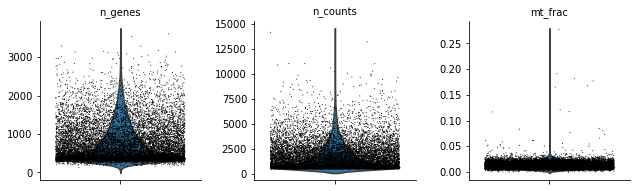

In [15]:
# Quality control - plot QC metrics
sc.pl.violin(adata, ['n_genes', 'n_counts', 'mt_frac'],
             jitter=0.4, multi_panel=True)

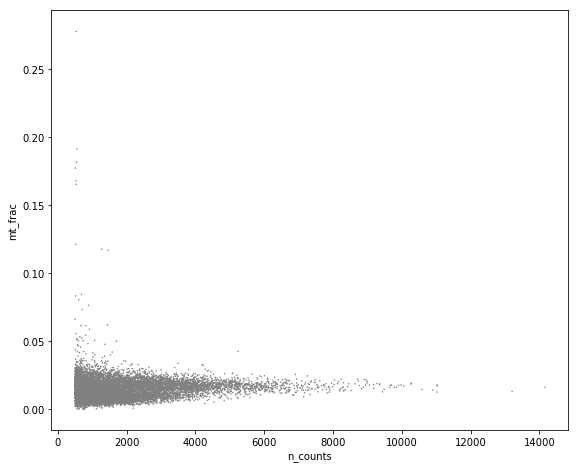

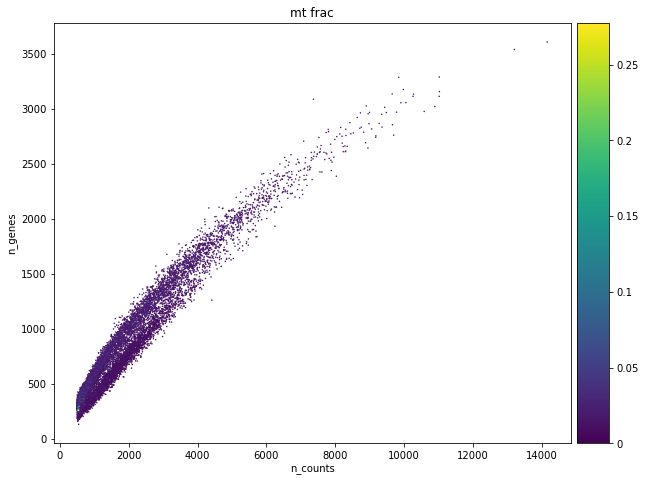

In [16]:
sc.pl.scatter(adata, x='n_counts', y='mt_frac')
sc.pl.scatter(adata, x='n_counts', y='n_genes', color='mt_frac')

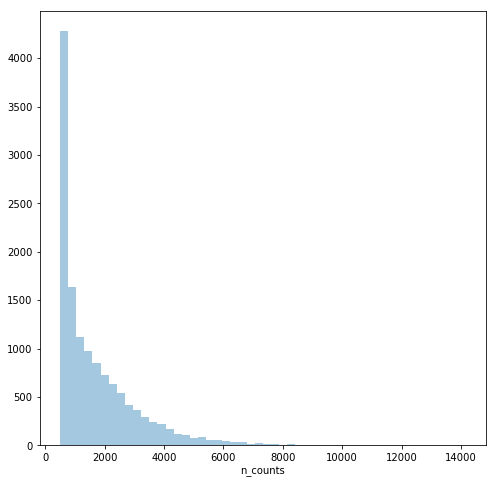

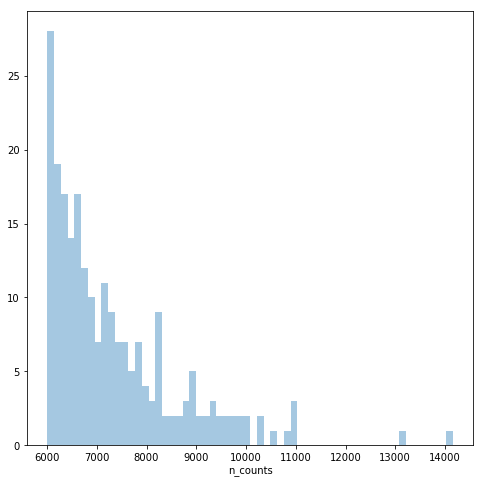

In [18]:
#Thresholding decision: counts
p3 = sb.distplot(adata.obs['n_counts'], kde=False)
plt.show()

p5 = sb.distplot(adata.obs['n_counts'][adata.obs['n_counts']>6000], kde=False, bins=60)
plt.show()

In [19]:
# Filter cells according to identified QC thresholds:
print('Total number of cells: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, max_counts = 11000)
print('Number of cells after max count filter: {:d}'.format(adata.n_obs))

adata = adata[adata.obs['mt_frac'] < 0.2]
print('Number of cells after MT filter: {:d}'.format(adata.n_obs))


Total number of cells: 13177
filtered out 5 cells that havemore than 11000 counts
Number of cells after max count filter: 13172
Number of cells after MT filter: 13171


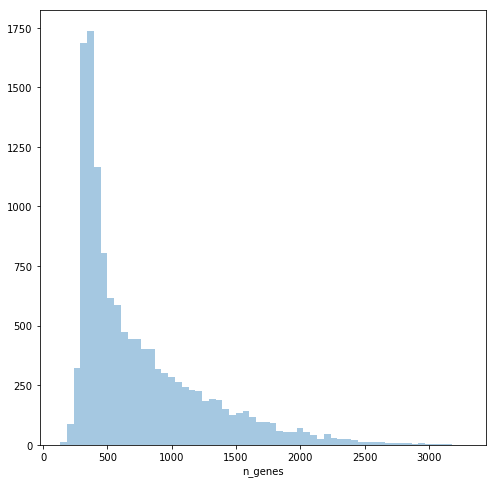

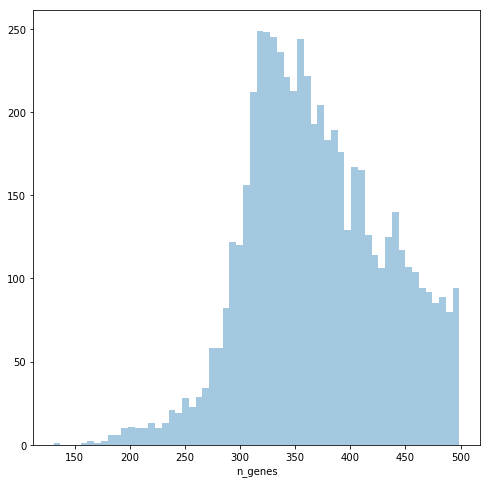

In [20]:
#Thresholding decision: genes
p6 = sb.distplot(adata.obs['n_genes'], kde=False, bins=60)
plt.show()

p7 = sb.distplot(adata.obs['n_genes'][adata.obs['n_genes']< 500], kde=False, bins=60)
plt.show()



From the histograms of the number of genes per cell, we can notice that there still is a small population showing n_genes < 200 which should be filtered out.

In [21]:
# Thresholding on number of genes
print('Total number of cells: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, min_genes = 200)
print('Number of cells after gene filter: {:d}'.format(adata.n_obs))

Total number of cells: 13171
filtered out 31 cells that haveless than 200 genes expressed


Trying to set attribute `.obs` of view, making a copy.


Number of cells after gene filter: 13140


In [22]:
#Filter genes:
print('Total number of genes: {:d}'.format(adata.n_vars))

# Min 10 cells - filters out 0 count genes
sc.pp.filter_genes(adata, min_cells=10)
print('Number of genes after cell filter: {:d}'.format(adata.n_vars))

Total number of genes: 20599
filtered out 6970 genes that are detectedin less than 10 cells
Number of genes after cell filter: 13629


## 1.2 Normalization

In [23]:
#Perform a clustering for scran normalization in clusters
adata_pp = adata.copy()
sc.pp.normalize_per_cell(adata_pp, counts_per_cell_after=1e6)
sc.pp.log1p(adata_pp)
sc.pp.pca(adata_pp, n_comps=15, svd_solver='arpack')
sc.pp.neighbors(adata_pp)
sc.tl.louvain(adata_pp, key_added='groups', resolution=0.5)

normalizing by total count per cell
    finished (0:00:01): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
computing PCA with n_comps = 15
    finished (0:00:08)
computing neighbors
    using 'X_pca' with n_pcs = 15
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:07)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 8 clusters and added
    'groups', the cluster labels (adata.obs, categorical) (0:00:02)


In [24]:
# Check if the minimum number of cells per cluster is < 21:in that case, sizes will be also passed as input to the normalization
adata_pp.obs['groups'].value_counts()

0    3410
1    2159
2    2126
3    1791
4    1488
5    1220
6     631
7     315
Name: groups, dtype: int64

In [25]:
#Preprocess variables for scran normalization
input_groups = adata_pp.obs['groups']
data_mat = adata.X.T

In [26]:
%%R -i data_mat -i input_groups -o size_factors

size_factors = computeSumFactors(data_mat, clusters=input_groups, min.mean=0.1)

In [27]:
#Delete adata_pp
del adata_pp

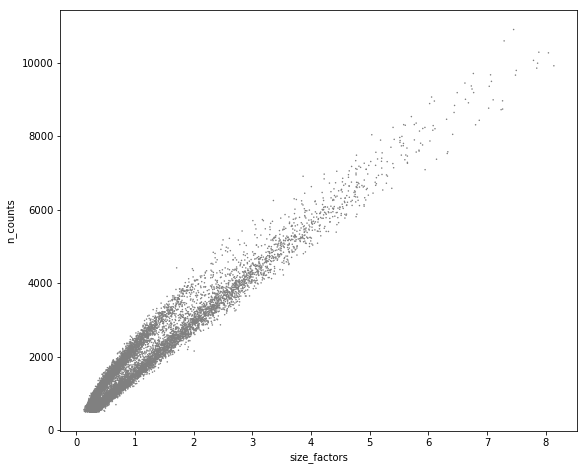

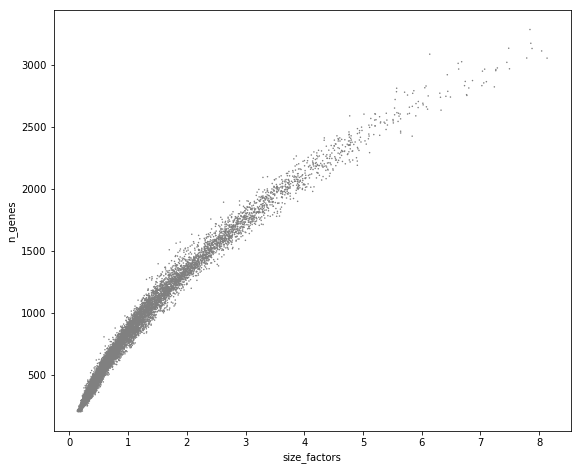

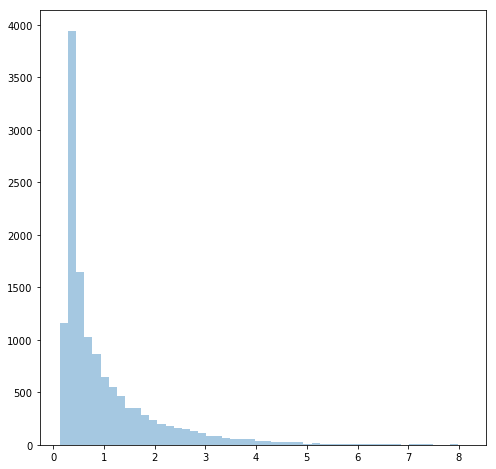

In [28]:
# Visualize the estimated size factors
adata.obs['size_factors'] = size_factors

sc.pl.scatter(adata, 'size_factors', 'n_counts')
sc.pl.scatter(adata, 'size_factors', 'n_genes')

sb.distplot(size_factors, bins=50, kde=False)
plt.show()

In [29]:
#Keep the count data in a counts layer
adata.layers["counts"] = adata.X.copy()

In [30]:
#Normalize adata 
adata.X /= adata.obs['size_factors'].values[:,None]
sc.pp.log1p(adata)

In [31]:
# Store the full data set in 'raw' as log-normalised data for statistical testing
adata.raw = adata

## 1.3 Highly variable genes

In [32]:
sc.pp.highly_variable_genes(adata, flavor='cell_ranger', n_top_genes=4000)
print('\n','Number of highly variable genes: {:d}'.format(np.sum(adata.var['highly_variable'])))

extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)

 Number of highly variable genes: 4000


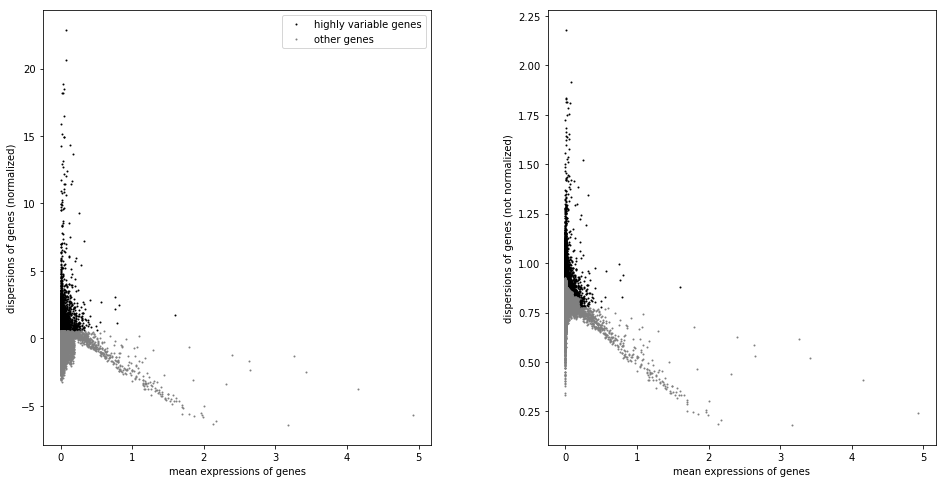

In [33]:
sc.pl.highly_variable_genes(adata)

# 2. Visualization

In [34]:
# Calculate the visualizations
sc.pp.pca(adata, n_comps=50, use_highly_variable=True, svd_solver='arpack')
sc.pp.neighbors(adata)

sc.tl.umap(adata)
sc.tl.diffmap(adata)
sc.tl.draw_graph(adata)

computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:05)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:05)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:15)
computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.98761284 0.9868846  0.9863036  0.9842123  0.9776245
     0.9722693  0.96704054 0.96501166 0.94551027 0.93482393 0.9287354
     0.9238102  0.91992384 0.9166201 ]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:00)
drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm) (0:03:19)


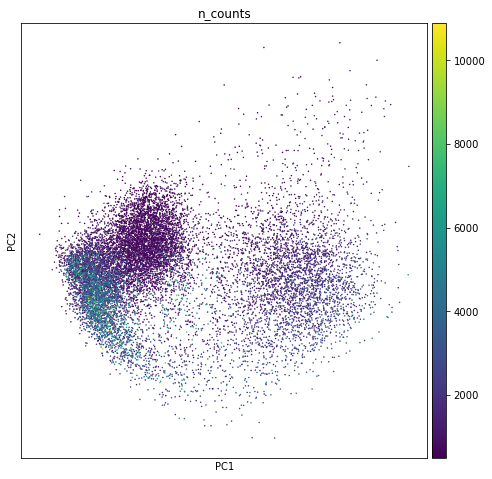

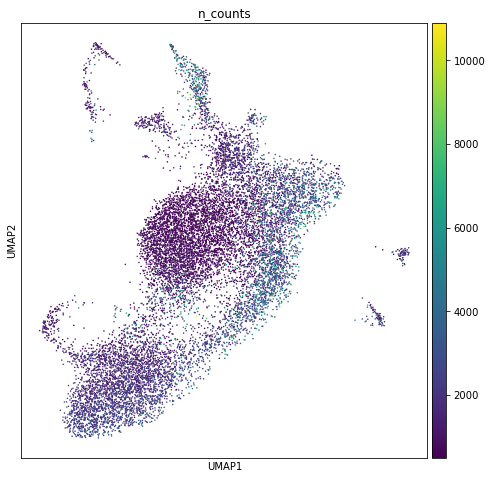

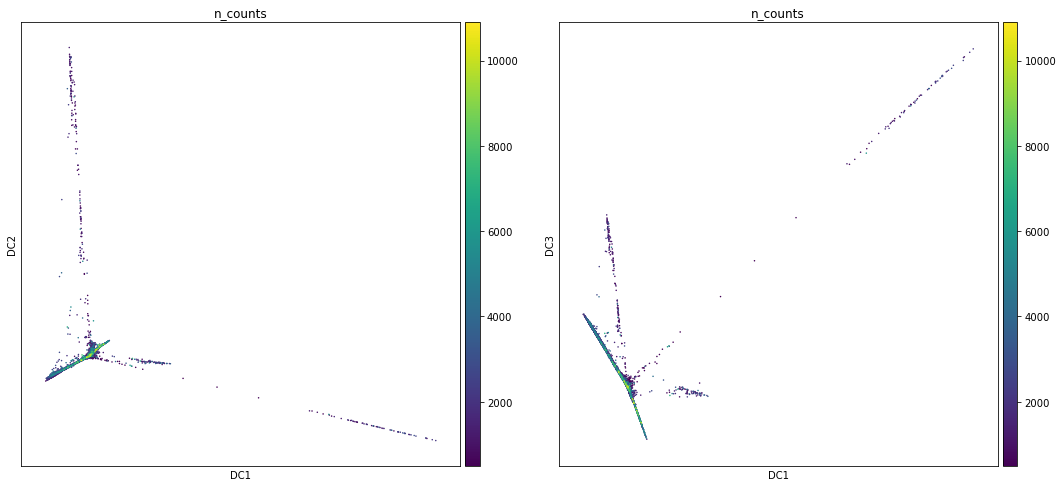

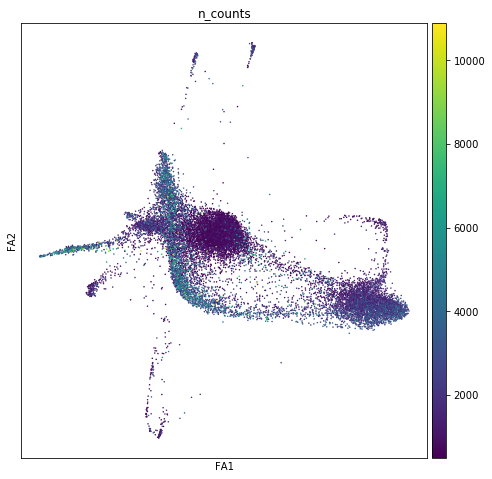

In [35]:
sc.pl.pca_scatter(adata, color='n_counts')
sc.pl.umap(adata, color='n_counts')
sc.pl.diffmap(adata, color='n_counts', components=['1,2','1,3'])
sc.pl.draw_graph(adata, color='n_counts')

In [36]:
adata.write(results_file)

# 3. Clustering

In [37]:
# Perform clustering - using highly variable genes
sc.tl.louvain(adata, key_added='louvain_r1')

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 12 clusters and added
    'louvain_r1', the cluster labels (adata.obs, categorical) (0:00:01)


In [38]:
adata.obs['louvain_r1'].value_counts()

0     3682
1     3590
2     1660
3     1633
4      868
5      579
6      454
7      223
8      157
9      153
10      75
11      66
Name: louvain_r1, dtype: int64

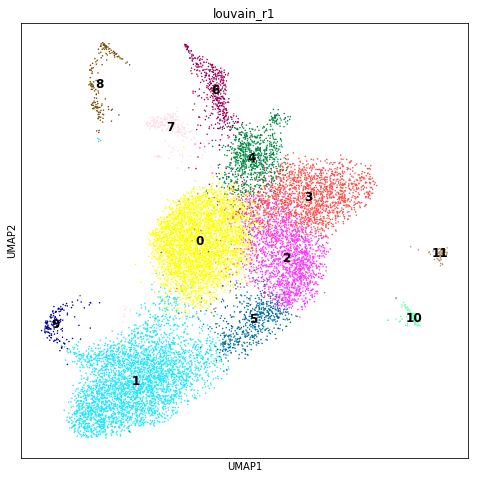

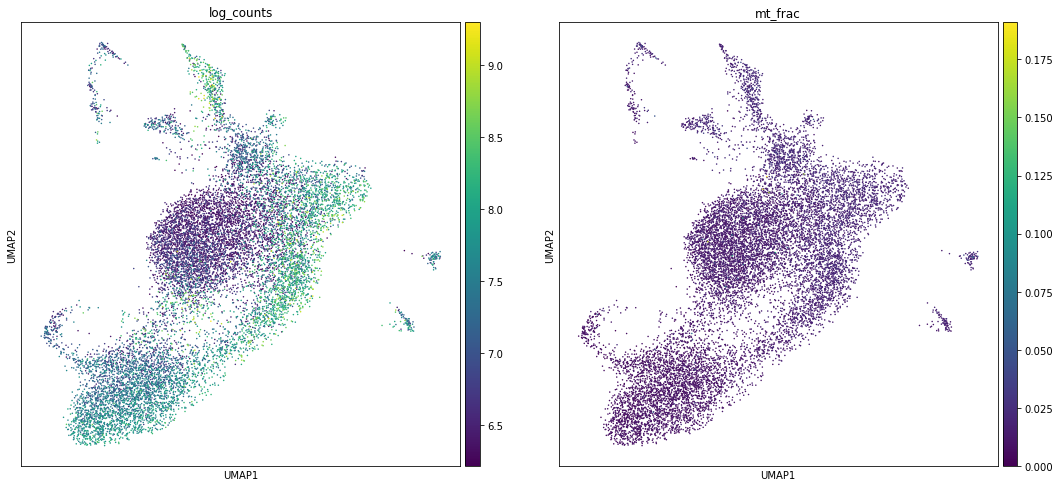

In [39]:
#Visualize the clustering and how this is reflected by different technical covariates
sc.pl.umap(adata, color=['louvain_r1'], palette=sc.pl.palettes.default_64, legend_loc='on data', legend_fontsize=12)
sc.pl.umap(adata, color=['log_counts', 'mt_frac'])



# 4. MCA cell type classification
Here we want to annotate the cells with the published classification from the Mouse Cell Atlas. We downloaded the cell annotations from this link. This would serve us as a reference map to identify cell types that share the same markers genes as the one identified for human samples.

In [40]:
mca_class = pd.read_csv('../Munich/datasets/mouse/MCA_CellAssignments.csv')
mca_class.head()

Unnamed: 0                     Cell.name   ClusterID   Tissue      Batch  \
0           1  Bladder_1.AAAACGAAAACGGGGCGA   Bladder_1  Bladder  Bladder_1   
1           2  Bladder_1.AAAACGAAGCGGCCGCTA   Bladder_5  Bladder  Bladder_1   
2           3  Bladder_1.AAAACGAAGTACTAGCAT  Bladder_16  Bladder  Bladder_1   
3           4  Bladder_1.AAAACGACGTTGCTGTGT   Bladder_8  Bladder  Bladder_1   
4           5  Bladder_1.AAAACGAGCGAGCGAGTA   Bladder_4  Bladder  Bladder_1   

         Cell.Barcode                                       Annotation  
0  AAAACGAAAACGGGGCGA                   Stromal cell_Dpt high(Bladder)  
1  AAAACGAAGCGGCCGCTA                  Stromal cell_Car3 high(Bladder)  
2  AAAACGAAGTACTAGCAT  Vascular smooth muscle progenitor cell(Bladder)  
3  AAAACGACGTTGCTGTGT               Vascular endothelial cell(Bladder)  
4  AAAACGAGCGAGCGAGTA                              Urothelium(Bladder)

In [41]:
# Select only tissue of interest
BM_class = mca_class[mca_class['Tissue'] == 'Bone-Marrow_c-kit']
BM_class.shape

(26483, 7)

In [42]:
# Prepare the data to be merged to adata.obs, to match the annotation with the correct barcode
bm_df = BM_class[['Cell.name', 'Annotation']].rename(columns = {'Cell.name':'barcode', 'Annotation':'MCA_annotation'})
bm_df['MCA_annotation'] = [i.split('(')[0] for i in bm_df['MCA_annotation']]
bm_df.head()

barcode                       MCA_annotation
2746  BoneMarrowcKit_1.AAAACGAACCTATGCGGA                  Monocyte progenitor
2747  BoneMarrowcKit_1.AAAACGAAGTACGTCGGT   Multipotent progenitor_Ctla2a high
2748  BoneMarrowcKit_1.AAAACGACAATACTCCAT  Monocyte progenitor cell_Prtn3 high
2749  BoneMarrowcKit_1.AAAACGACAATAGCCCTC                  Monocyte progenitor
2750  BoneMarrowcKit_1.AAAACGACGAGCGTAATG                             Basophil

In [43]:
# save adata.obs as a dataframe and make barcodes column accessible
adata_df = adata.obs.reset_index()
adata_df.head()

barcode  n_counts  log_counts  n_genes  \
0  BoneMarrowcKit_2.CGGCAGGTTGCCAAGCGG   10897.0    9.296243     3021   
1  BoneMarrowcKit_2.GACACTAACCTATGGATG    7827.0    8.965335     2549   
2  BoneMarrowcKit_2.CGGCAGCCGACGTAGTCG   10588.0    9.267477     2976   
3  BoneMarrowcKit_2.TTCCGCTCAAAGGGGCGA    9279.0    9.135509     2867   
4  BoneMarrowcKit_2.ACACCCAGATGGGCCCTC    8529.0    9.051228     2780   

    mt_frac  size_factors louvain_r1  
0  0.013857      7.450166          5  
1  0.011626      5.513502          1  
2  0.014261      7.288660          5  
3  0.018644      6.741795          0  
4  0.013483      5.708622          0

In [44]:
# merge the two dataframes
adata_merge = adata_df.merge(bm_df, how='left', on='barcode')
adata_merge.head()

barcode  n_counts  log_counts  n_genes  \
0  BoneMarrowcKit_2.CGGCAGGTTGCCAAGCGG   10897.0    9.296243     3021   
1  BoneMarrowcKit_2.GACACTAACCTATGGATG    7827.0    8.965335     2549   
2  BoneMarrowcKit_2.CGGCAGCCGACGTAGTCG   10588.0    9.267477     2976   
3  BoneMarrowcKit_2.TTCCGCTCAAAGGGGCGA    9279.0    9.135509     2867   
4  BoneMarrowcKit_2.ACACCCAGATGGGCCCTC    8529.0    9.051228     2780   

    mt_frac  size_factors louvain_r1                      MCA_annotation  
0  0.013857      7.450166          5  Monocyte progenitor cell_Ctsg high  
1  0.011626      5.513502          1                Neutrophil_Fcnb high  
2  0.014261      7.288660          5  Monocyte progenitor cell_Ctsg high  
3  0.018644      6.741795          0    Erythrocyte progenitor_Car1 high  
4  0.013483      5.708622          0  Monocyte progenitor cell_Ctsg high

In [45]:
# reassign merged dataframe as adata.obs
adata_merge.set_index('barcode', inplace = True)
adata.obs = adata_merge

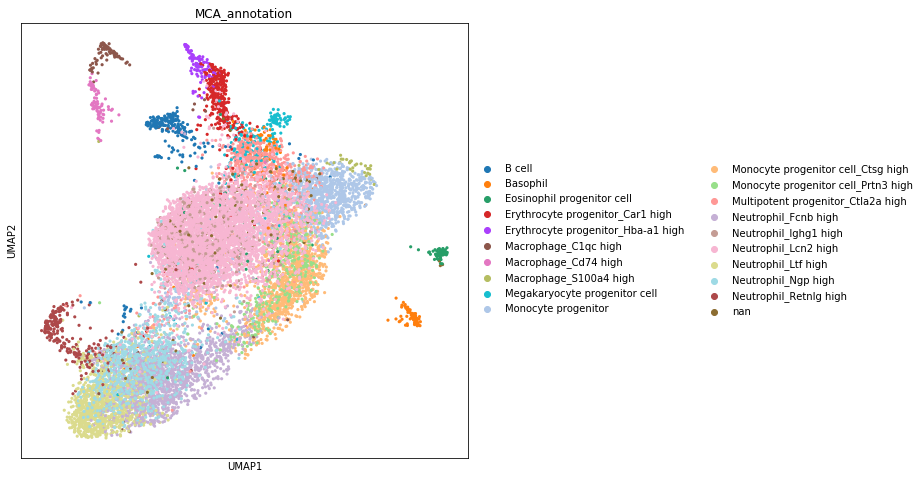

In [53]:
sc.pl.umap(adata, color='MCA_annotation', size = 40)

# 5. Plot makers of subtypes

Here we plot the markers that identified cell types in the human BM/ PBMCs.

In [7]:
#Define a nice colour map for gene expression
colors2 = plt.cm.Reds(np.linspace(0, 1, 128))
colors3 = plt.cm.Greys_r(np.linspace(0.7,0.8,20))
colorsComb = np.vstack([colors3, colors2])
mymap = colors.LinearSegmentedColormap.from_list('my_colormap', colorsComb)

## T cells

We want to annotate CD8+ versus CD4+ cells.
For the labels to be consistent with the MCA-derived, we check the expression of those markers as well (when possible).

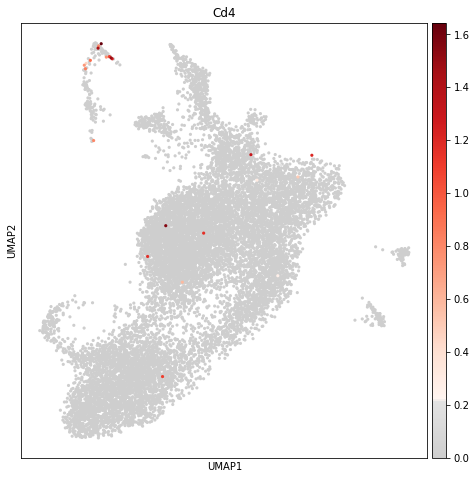

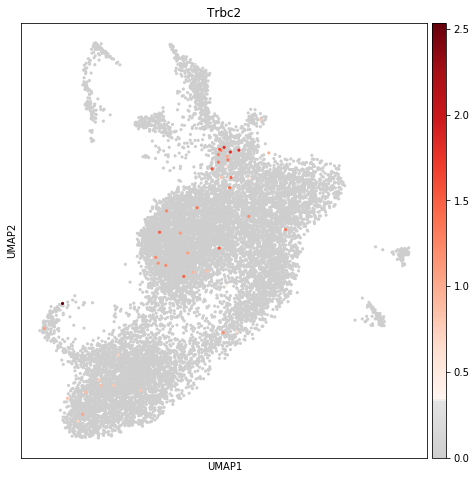

In [54]:
#Canonical markers  #Cd8a and Cd8b not present
sc.pl.umap(adata, color=['Cd4'], use_raw=False, color_map=mymap, size = 40)

# Markers from MCA not there
sc.pl.umap(adata, color=['Trbc2'], use_raw=False, color_map=mymap, size = 40)

## NK cells

We consider NK cells as CD8- CD4-. NKT cells are instead CD8+/CD4+ and NKG7/GZMA +.

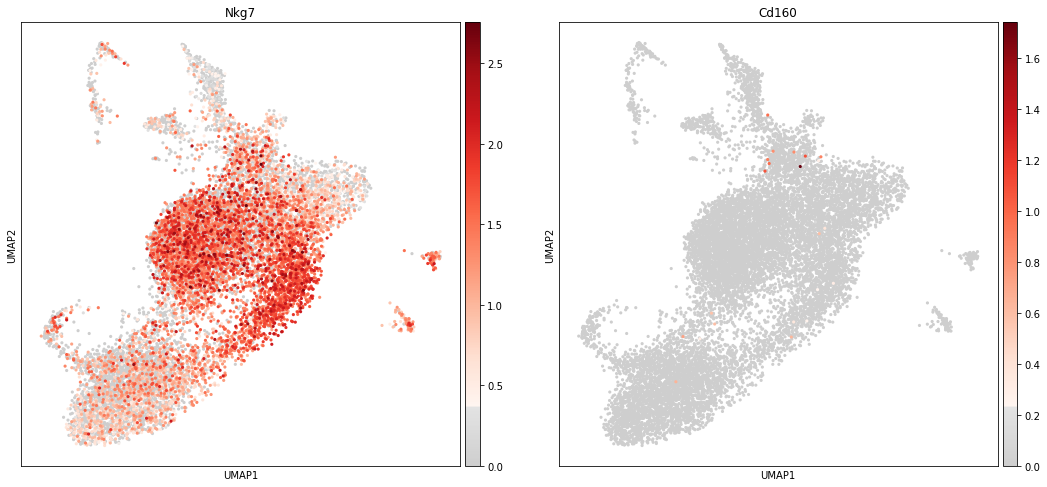

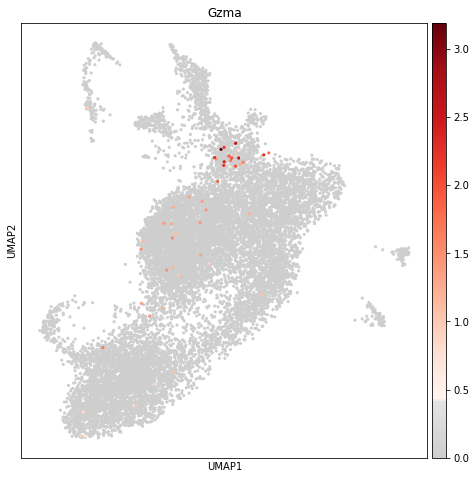

In [59]:
# Gnly not present
sc.pl.umap(adata, color=['Nkg7', 'Cd160'], use_raw=False, color_map=mymap, size = 40)

# marker from MCA 
sc.pl.umap(adata, color=['Gzma'], use_raw=False, color_map=mymap, size = 40)

## Monocytes: CD14+ and CD16+

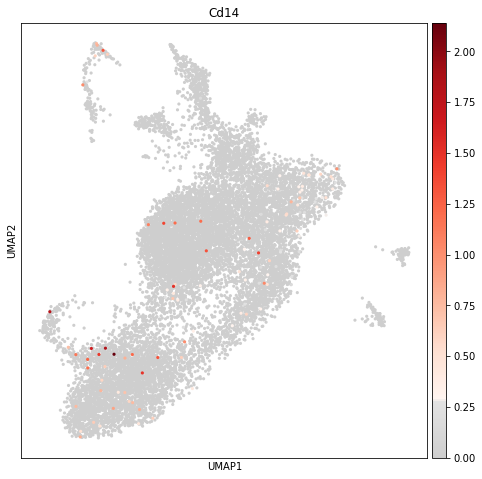

In [62]:
# Fcgr3a not present
sc.pl.umap(adata, color=['Cd14'], use_raw=False, color_map=mymap, size = 40)

## Monocytes progenitors

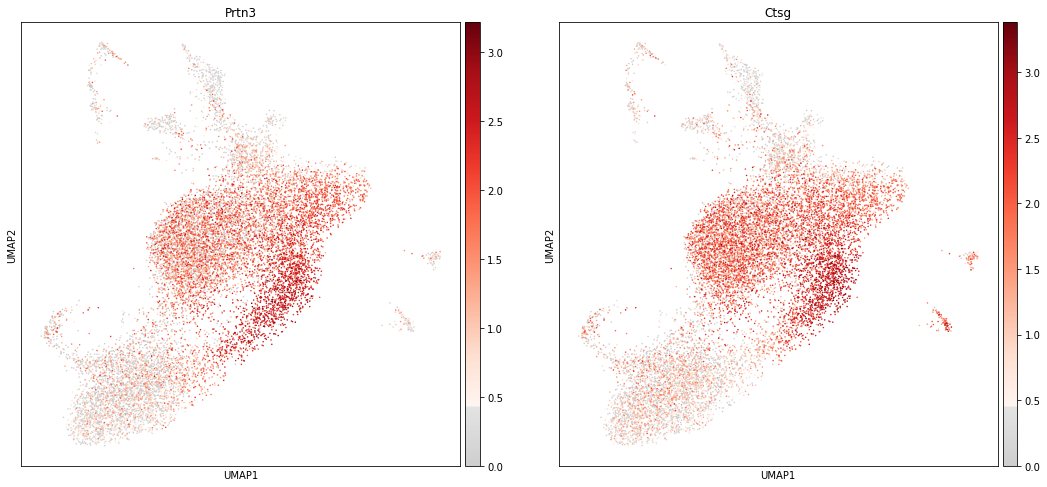

In [63]:
# Markers from MCA
sc.pl.umap(adata, color=['Prtn3','Ctsg'], use_raw=False, color_map=mymap)

## Monocyte-derived Dendritic cells

Here we use markers from [Sinha et al.](https://www.ncbi.nlm.nih.gov/pubmed/29361178)

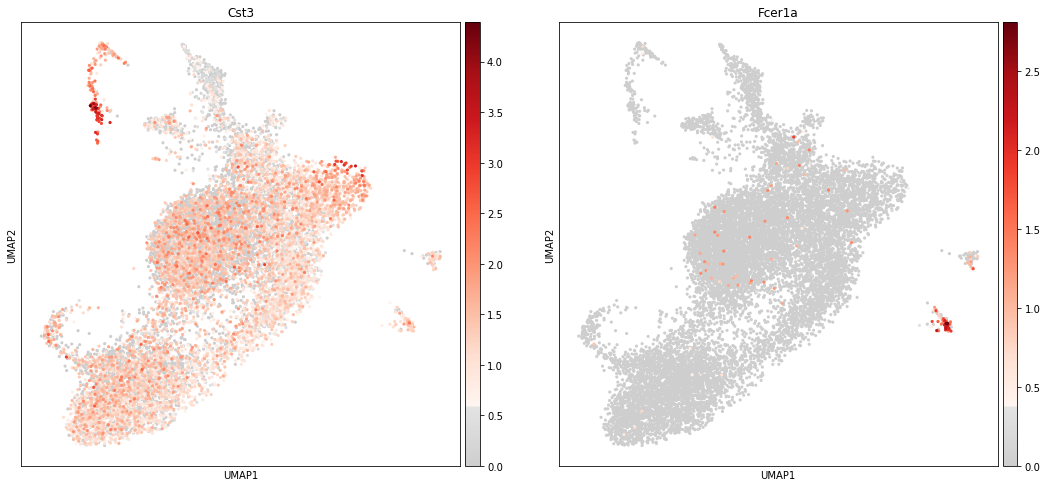

In [69]:
# Cd1c not present
sc.pl.umap(adata, color=['Cst3', 'Fcer1a'], use_raw=False, color_map=mymap, size = 40)

## Plasmacytoid dendritic cells

Here we use markers from [Sinha et al.](https://www.ncbi.nlm.nih.gov/pubmed/29361178)

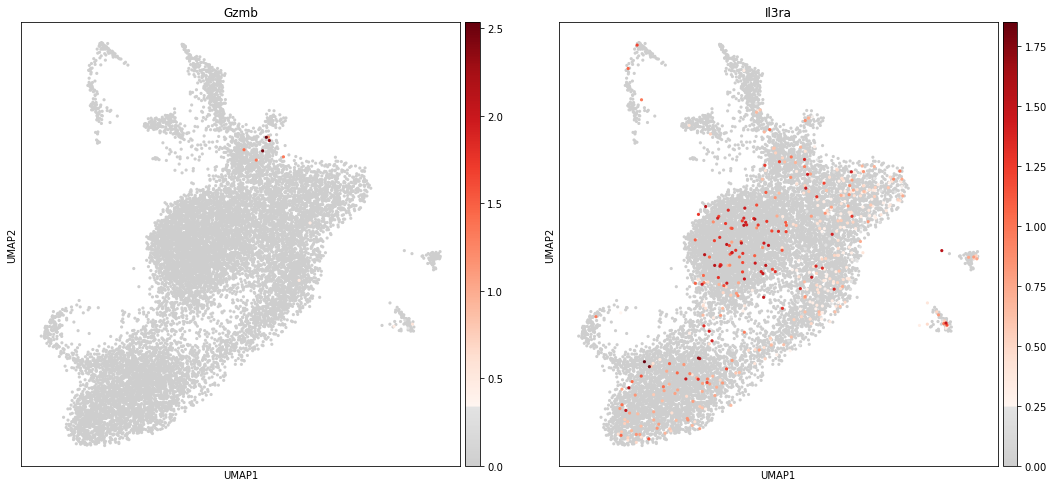

In [70]:
sc.pl.umap(adata, color=['Gzmb', 'Il3ra'], use_raw=False, color_map=mymap, size = 40)

## B cells

Oetjen et al. annotates B cells as CD20+ (MS4A1) or CD10+ (MME).


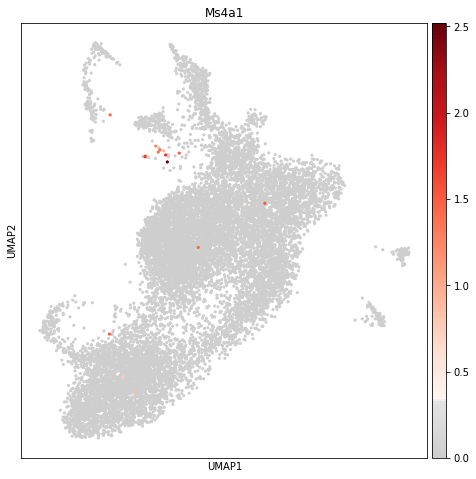

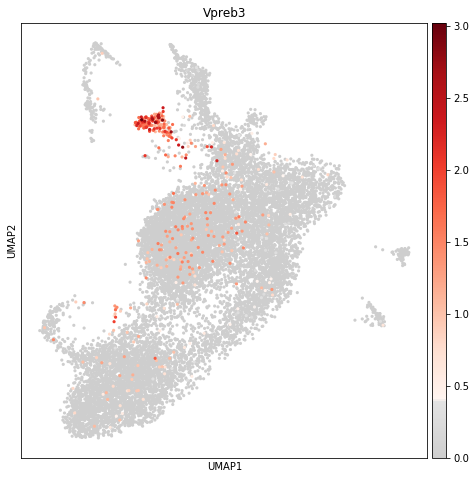

In [72]:
# Oetjen # Mme not present
sc.pl.umap(adata, color=['Ms4a1'], use_raw=False, color_map=mymap, size = 40)

# markers from MCA
sc.pl.umap(adata, color=['Vpreb3'], use_raw=False, color_map=mymap, size = 40)

## Hematopoietic stem progenitors cells (HSPCs)

Using markers from [CellMarker](http://biocc.hrbmu.edu.cn/CellMarker/search.jsp?quickSearchInfo=bone%20marrow)

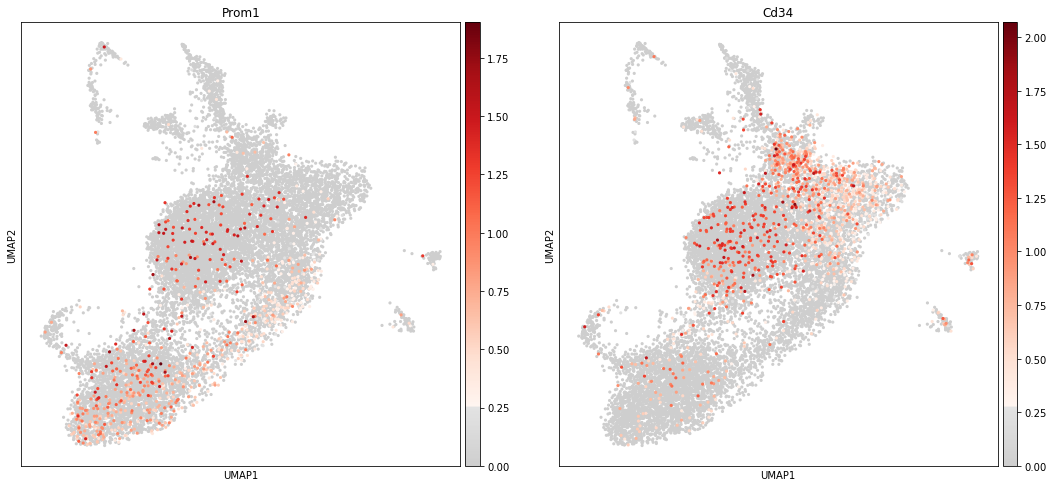

In [74]:
sc.pl.umap(adata, color=['Prom1', 'Cd34'], use_raw=False, color_map=mymap, size = 40)

## Erythrocytes

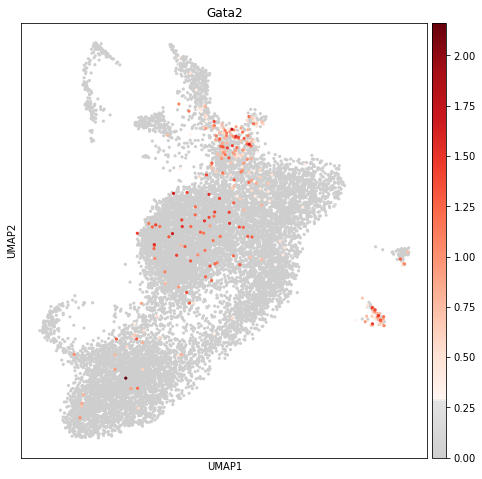

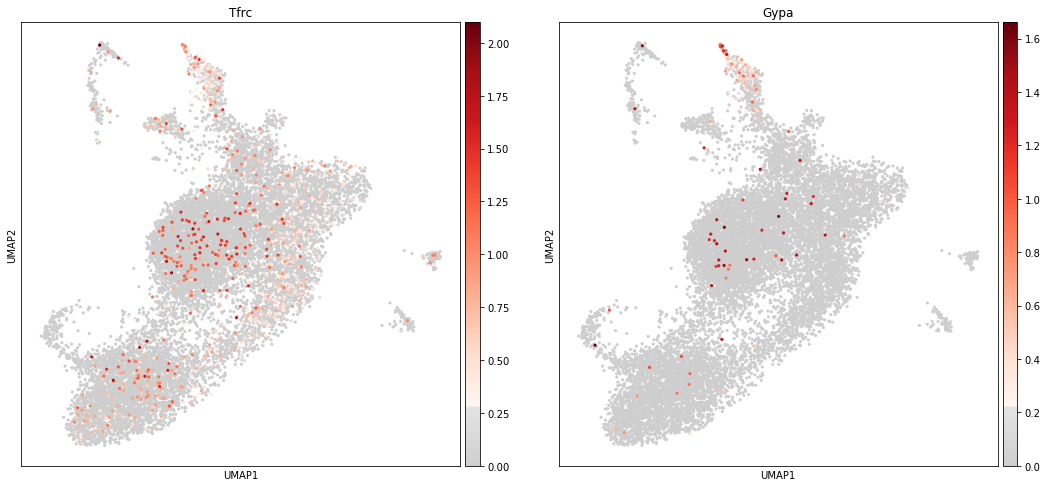

In [78]:
# Erythrocytes progenitors
sc.pl.umap(adata, color=['Gata2'], use_raw=False, color_map=mymap, size = 40)

# markers from CellMarker (differentiated) 
sc.pl.umap(adata, color=['Tfrc', 'Gypa'], use_raw=False, color_map=mymap, size = 40)

# markers from Oetjen and MCA (differentiated) not there
#sc.pl.umap(adata, color=['Hbd','Hba1'], use_raw=False, color_map=mymap, size = 40)

## Plasma cells

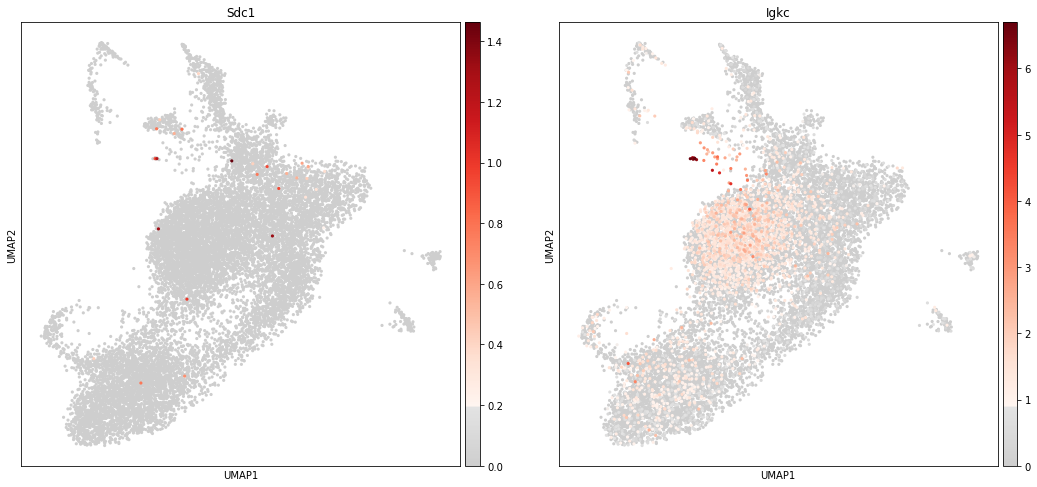

In [79]:
# From CellMarker
sc.pl.umap(adata, color=['Sdc1', 'Igkc'], use_raw=False, color_map=mymap, size = 40)

# Markers from Dahlin et al.

## Neutrophils

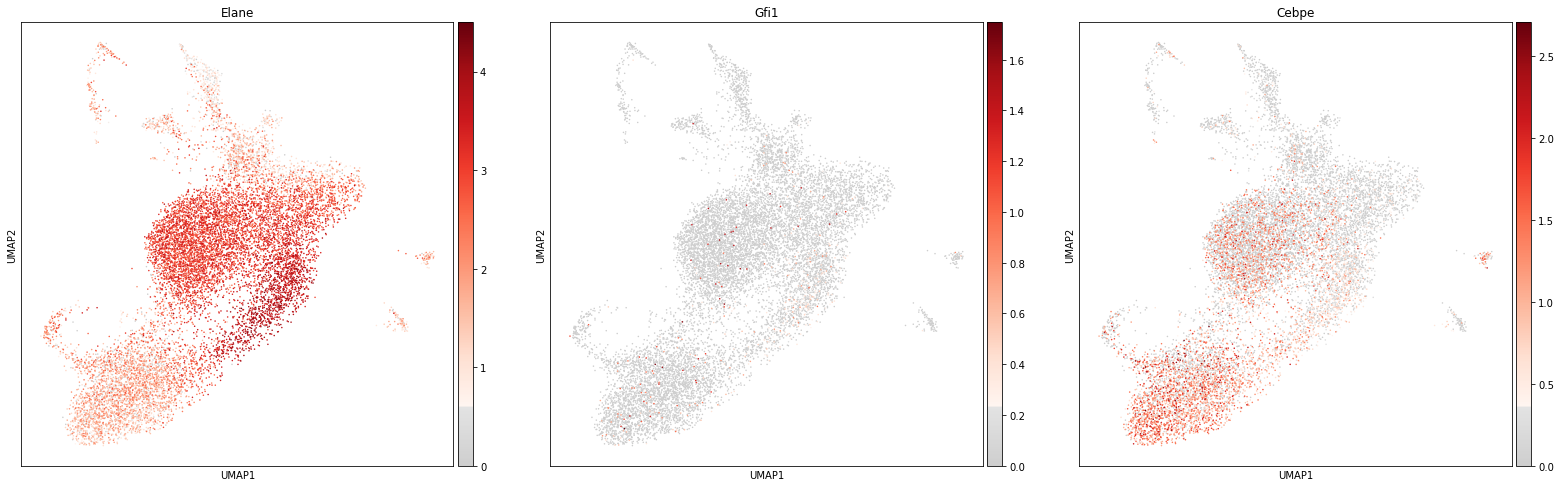

In [8]:
sc.pl.umap(adata, color=['Elane', 'Gfi1', 'Cebpe'], use_raw=False, color_map=mymap)

## Megakaryocyte progenitors

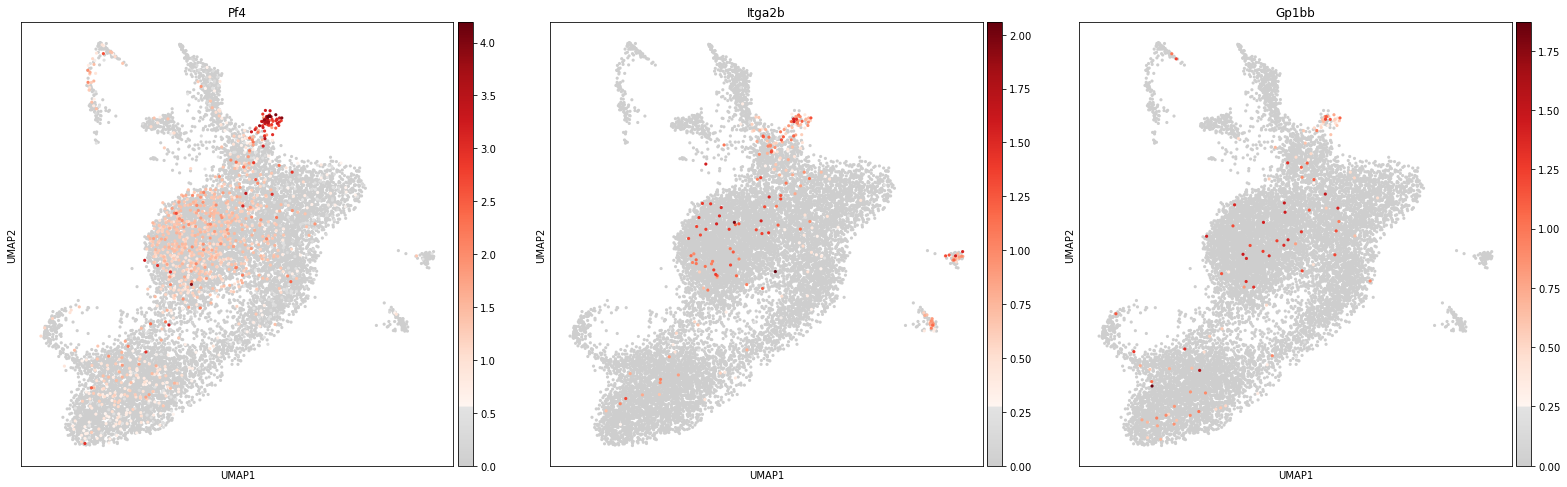

In [9]:
sc.pl.umap(adata, color=['Pf4', 'Itga2b', 'Gp1bb'], use_raw=False, color_map=mymap, size=40)

## Lymphoid progenitors

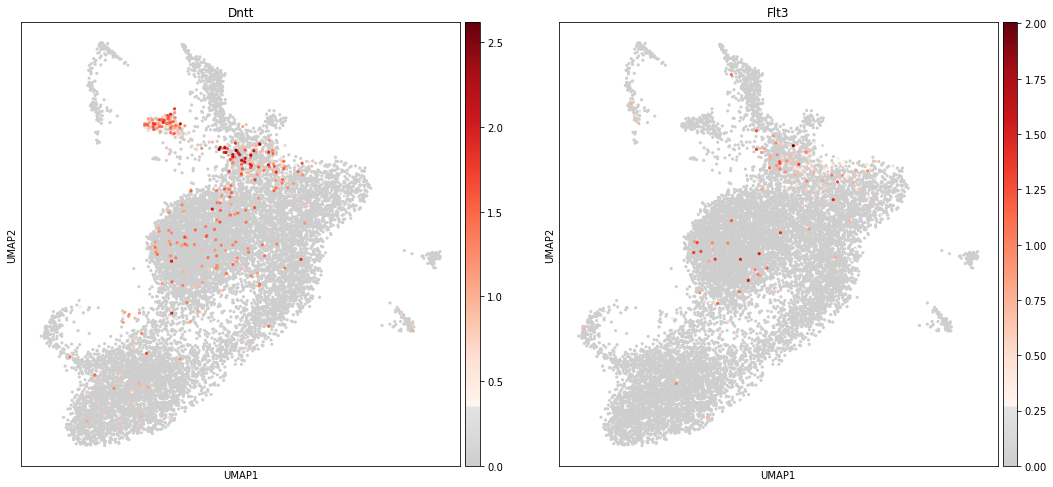

In [10]:
sc.pl.umap(adata, color=['Dntt', 'Flt3'], use_raw=False, color_map=mymap, size=40)

## HSPCs

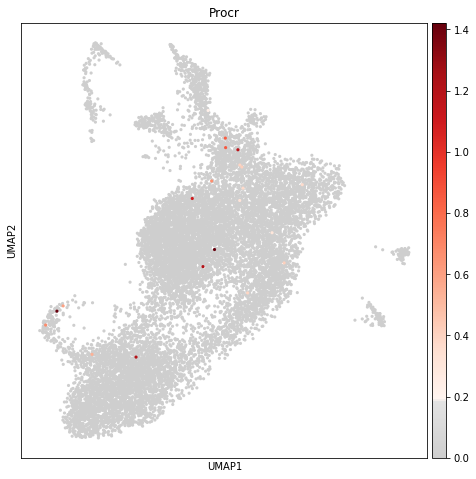

In [11]:
sc.pl.umap(adata, color=['Procr'], use_raw=False, color_map=mymap, size=40)

# 6. Final cell-type annotation - label harmonization


In [5]:
# Categories to rename
adata.obs['final_annotation'] = adata.obs['MCA_annotation']
tmp = adata.obs['final_annotation']
tmp = ['Erythrocytes' if item.startswith('Erythrocyte') else item for item in tmp]
tmp = ['Neutrophils' if item.startswith('Neutrophil') else item for item in tmp]
tmp = ['Monocyte progenitors' if item.startswith('Monocyte progenitor') else item for item in tmp]
tmp = ['HSPCs + Lymphocyte progenitors' if item.startswith('Multipotent') else item for item in tmp]
tmp = ['Monocytes' if item.startswith('Macrophage') else item for item in tmp]
tmp = ['Basophils' if item.startswith('Basophil') else item for item in tmp]
tmp = ['Megakaryocyte progenitors' if item.startswith('Megakaryocyte') else item for item in tmp]
tmp = ['B cells' if item.startswith('B cell') else item for item in tmp]
adata.obs['final_annotation'] = tmp
adata = adata[adata.obs['final_annotation'] != 'nan']

Trying to set attribute `.obs` of view, making a copy.
... storing 'final_annotation' as categorical


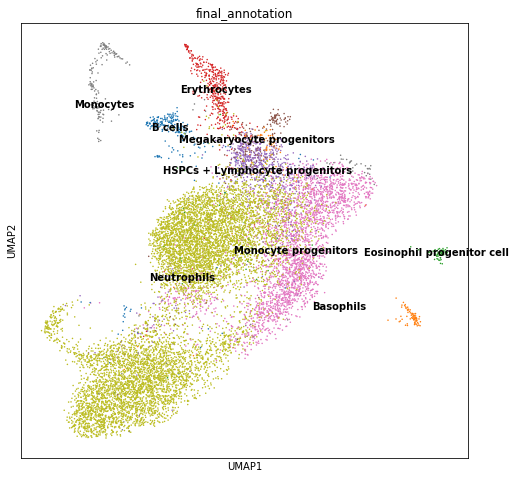

In [6]:
sc.pl.umap(adata, color='final_annotation', legend_loc='on data')

In [82]:
# save final result
adata.write(results_file)

# Erythrocyte differentiation
Here we want to investigate the trajectory of erythrocytes differentiation using PAGA and DPT.

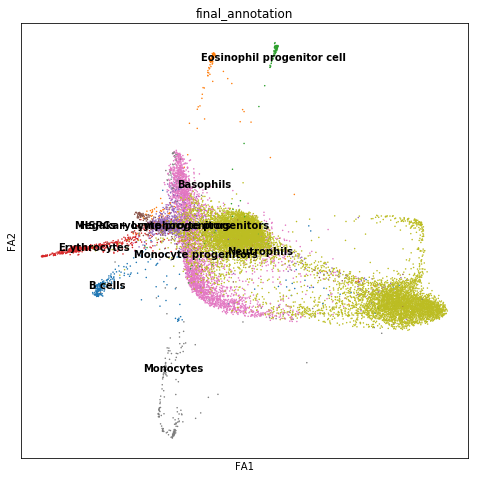

In [7]:
sc.pl.draw_graph(adata, color='final_annotation', legend_loc='on data')

In [8]:
sc.tl.paga(adata, groups='final_annotation')

running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)


--> added 'pos', the PAGA positions (adata.uns['paga'])


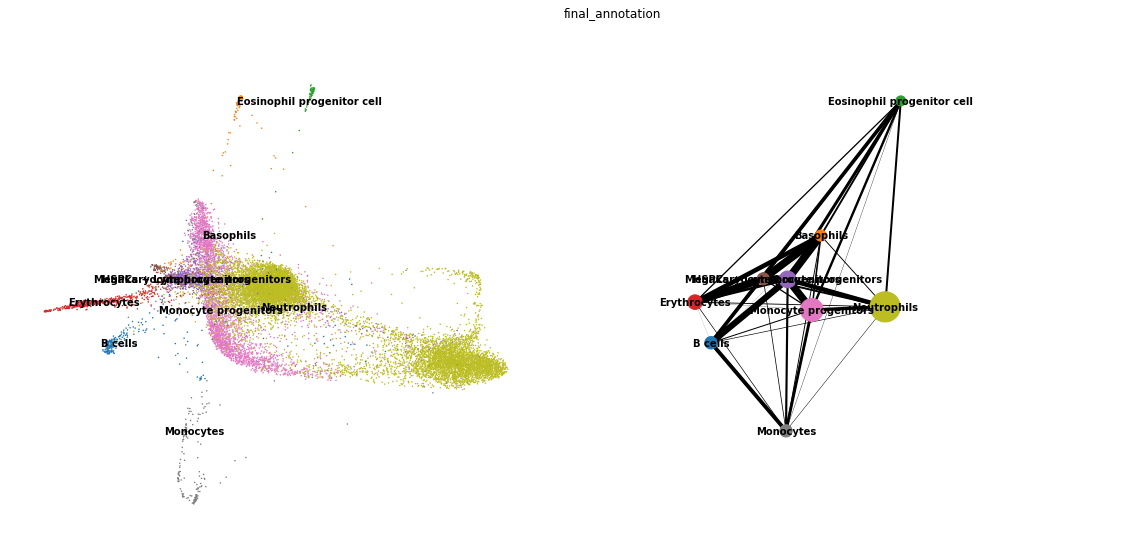

In [9]:
sc.pl.paga_compare(adata, color='final_annotation')

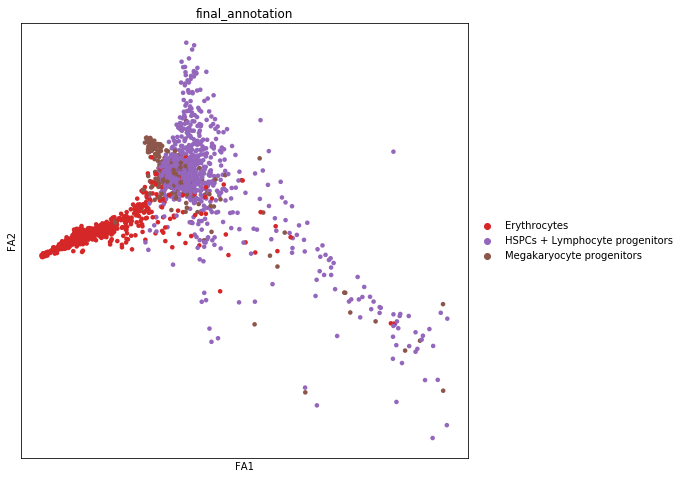

In [6]:
# Subsetting adata to only the clusters included in the trajectory
adata_ery = adata[adata.obs['final_annotation'].isin(['HSPCs + Lymphocyte progenitors', 'Megakaryocyte progenitors', 'Erythrocytes'])]
sc.pl.draw_graph(adata_ery, color='final_annotation')

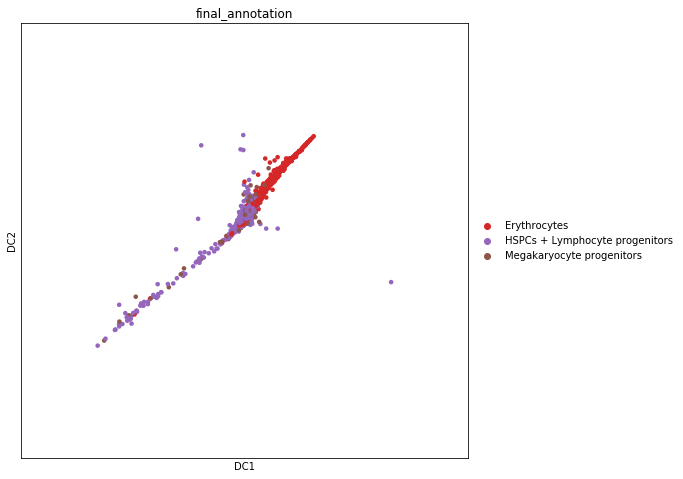

In [7]:
sc.pl.diffmap(adata_ery, components='1,2', color='final_annotation')

In DPT we must assign a root cell to infer pseudotime. We do so by looking at the diffmap plots and choosing the root cell as the one with the minimum DC1 value.

In [8]:
# Calculate pseudotime with DPT
root_mask = adata_ery.obs.final_annotation.isin(['HSPCs + Lymphocyte progenitors'])
max_root_id = np.argmin(adata_ery.obsm['X_diffmap'][root_mask,1])
root_id = np.arange(len(root_mask))[root_mask][max_root_id]
adata_ery.uns['iroot'] = root_id

sc.tl.dpt(adata_ery, n_branchings=0, n_dcs=15)

computing Diffusion Pseudotime using n_dcs=15
    finished: added
    'dpt_pseudotime', the pseudotime (adata.obs) (0:00:00)


In [9]:
# Save ordering of cells in the original adata object

# save adata_ery.obs as a dataframe and make barcodes column accessible
adata_ery_df = adata_ery.obs.reset_index()
# prepare adata_ery_df for merging
adata_ery_df = adata_ery_df[['barcode', 'dpt_pseudotime']]
# save adata.obs as a dataframe and make barcodes column accessible
adata_df = adata.obs.reset_index()
# merge the two dataframes
adata_merge = adata_df.merge(adata_ery_df, how='left', on='barcode')
# reassign merged dataframe as adata.obs
adata_merge.set_index('barcode', inplace = True)
adata.obs = adata_merge

In [10]:
# save final result
adata.write(results_file)